In [3]:
import sys
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install torch


     ---------------------------------------- 0.0/172.3 MB ? eta -:--:--
     --------------------------------------- 0.8/172.3 MB 24.1 MB/s eta 0:00:08
     --------------------------------------- 1.6/172.3 MB 20.5 MB/s eta 0:00:09
      -------------------------------------- 2.7/172.3 MB 21.9 MB/s eta 0:00:08
      -------------------------------------- 4.4/172.3 MB 25.5 MB/s eta 0:00:07
     - ------------------------------------- 6.7/172.3 MB 30.6 MB/s eta 0:00:06
     -- ------------------------------------ 9.6/172.3 MB 36.2 MB/s eta 0:00:05
     --- ---------------------------------- 13.7/172.3 MB 65.6 MB/s eta 0:00:03
     --- ---------------------------------- 17.7/172.3 MB 81.8 MB/s eta 0:00:02
     ---- --------------------------------- 20.7/172.3 MB 81.8 MB/s eta 0:00:02
     ----- -------------------------------- 24.4/172.3 MB 81.8 MB/s eta 0:00:02
     ------ ------------------------------- 28.1/172.3 MB 81.8 MB/s eta 0:00:02
     ------ ------------------------------- 31.

In [2]:
import numpy as np
import pandas as pd

import torch
from sklearn.model_selection import train_test_split

In [36]:
dataset = pd.read_csv('Data/all_data.csv')

#subtract the columns L_0_x, L_0_y, L_0_z from all the columns
for i in range(0, 21):
    dataset[f'L_{i}_x'] = dataset[f'L_{i}_x'] - dataset['L_0_x']
    dataset[f'L_{i}_y'] = dataset[f'L_{i}_y'] - dataset['L_0_y']
    # dataset[f'L_{i}_z'] = dataset[f'L_{i}_z'] - dataset['L_0_z']
    dataset[f'R_{i}_x'] = dataset[f'R_{i}_x'] - dataset['R_0_x']
    dataset[f'R_{i}_y'] = dataset[f'R_{i}_y'] - dataset['R_0_y']
    # dataset[f'R_{i}_z'] = dataset[f'R_{i}_z'] - dataset['R_0_z']

#write datatset to csv
dataset.to_csv('Data/relative_data.csv', index=False)

X = dataset.iloc[:, 1:]
Y = dataset.iloc[:, 0]

# Splitting the dataset into the Training set and Test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

# # Feature Scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

print(X_train)
print(Y_train)


      L_0_x  L_0_y         L_0_z     L_1_x     L_1_y     L_1_z     L_2_x  \
1203    0.0    0.0 -8.400023e-08  0.266729  0.687150 -0.018837  0.263162   
2776    0.0    0.0  1.210932e-07  0.677481  0.505590  0.004306  0.685553   
2426    0.0    0.0  8.222040e-08  0.335637  0.560987 -0.001398  0.369569   
2851    0.0    0.0 -1.161119e-08  0.796171  0.455274  0.014610  0.795620   
2583    0.0    0.0  5.750102e-07  0.394363  0.616842 -0.017514  0.431584   
...     ...    ...           ...       ...       ...       ...       ...   
2727    0.0    0.0  1.120270e-07  0.738163  0.554151 -0.004907  0.767290   
2721    0.0    0.0  2.595245e-07  0.747727  0.560304 -0.004722  0.781622   
2340    0.0    0.0  1.153505e-07  0.271102  0.407226  0.021277  0.283834   
2698    0.0    0.0  3.850827e-07  0.704953  0.619691 -0.014690  0.657817   
288     0.0    0.0  3.802554e-08  0.210687  0.475014 -0.016423  0.219422   

         L_2_y     L_2_z     L_3_x  ...    R_17_z    R_18_x    R_18_y  \
1203  0.618048

In [37]:
X_train_tensor = torch.tensor(X_train.values).float()
X_test_tensor = torch.tensor(X_test.values).float()
Y_train_tensor = torch.tensor(Y_train.values).long()
Y_test_tensor = torch.tensor(Y_test.values).long()

In [38]:
print(X_train_tensor.shape)
print(Y_train_tensor.shape)


torch.Size([2069, 126])
torch.Size([2069])


In [39]:
batch_size = 64
n_iters = 15000
num_epochs = n_iters / (len(X_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(X_train_tensor,Y_train_tensor)
test = torch.utils.data.TensorDataset(X_test_tensor,Y_test_tensor)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

In [40]:
class GestureFNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GestureFNN, self).__init__()
        # Linear function 1: 126 --> 84
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)

        # Non-linearity 1
        self.sigmoid = torch.nn.Sigmoid()

        # Linear function 2: 84 --> 3
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)

        # Non-linearity 1
        out = self.sigmoid(out)

        # Linear function 2 (readout)
        out = self.fc2(out)
        return out



In [41]:
model = GestureFNN(input_dim=126, hidden_dim=84, output_dim=3)

critereon = torch.nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [42]:
iter = 0
for epoch in range(num_epochs):
    for i, (landmarks, labels) in enumerate(train_loader):

        lanmarks = landmarks.view(-1, 126).requires_grad_()

        optimizer.zero_grad()

        outputs = model(landmarks)

        loss = critereon(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            correct = 0
            total = 0
            for landmarks, labels in test_loader:
                landmarks = landmarks.view(-1, 126).requires_grad_()

                outputs = model(landmarks)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.29286983609199524. Accuracy: 84.89289855957031
Iteration: 1000. Loss: 0.16265037655830383. Accuracy: 94.0248031616211
Iteration: 1500. Loss: 0.11745762825012207. Accuracy: 96.05411529541016
Iteration: 2000. Loss: 0.09519723802804947. Accuracy: 96.9560317993164
Iteration: 2500. Loss: 0.033439408987760544. Accuracy: 97.06877136230469
Iteration: 3000. Loss: 0.10177647322416306. Accuracy: 97.40699005126953
Iteration: 3500. Loss: 0.08079180866479874. Accuracy: 97.40699005126953
Iteration: 4000. Loss: 0.04557643458247185. Accuracy: 97.6324691772461
Iteration: 4500. Loss: 0.014474238269031048. Accuracy: 97.74520874023438
Iteration: 5000. Loss: 0.04792551323771477. Accuracy: 97.51972961425781
Iteration: 5500. Loss: 0.08303719758987427. Accuracy: 97.6324691772461
Iteration: 6000. Loss: 0.048574298620224. Accuracy: 97.85794830322266
Iteration: 6500. Loss: 0.033055830746889114. Accuracy: 97.97068786621094
Iteration: 7000. Loss: 0.08372822403907776. Accuracy: 97.85794830322

In [43]:
# test the model on the test set
correct = 0
total = 0
for landmarks, labels in test_loader:
    landmarks = landmarks.view(-1, 126).requires_grad_()

    outputs = model(landmarks)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)

    correct += (predicted == labels).sum()

accuracy = 100 * correct / total

print('Accuracy of the model on the test set: {}'.format(accuracy))


Accuracy of the model on the test set: 98.98534393310547


In [33]:
import sys
!{sys.executable} -m pip install seaborn

     ---------------------------------------- 0.0/293.3 kB ? eta -:--:--
     -------------------------------------  286.7/293.3 kB 8.9 MB/s eta 0:00:01
     -------------------------------------- 293.3/293.3 kB 6.0 MB/s eta 0:00:00


[[25  0  0]
 [ 0 19  0]
 [ 0  0 11]]


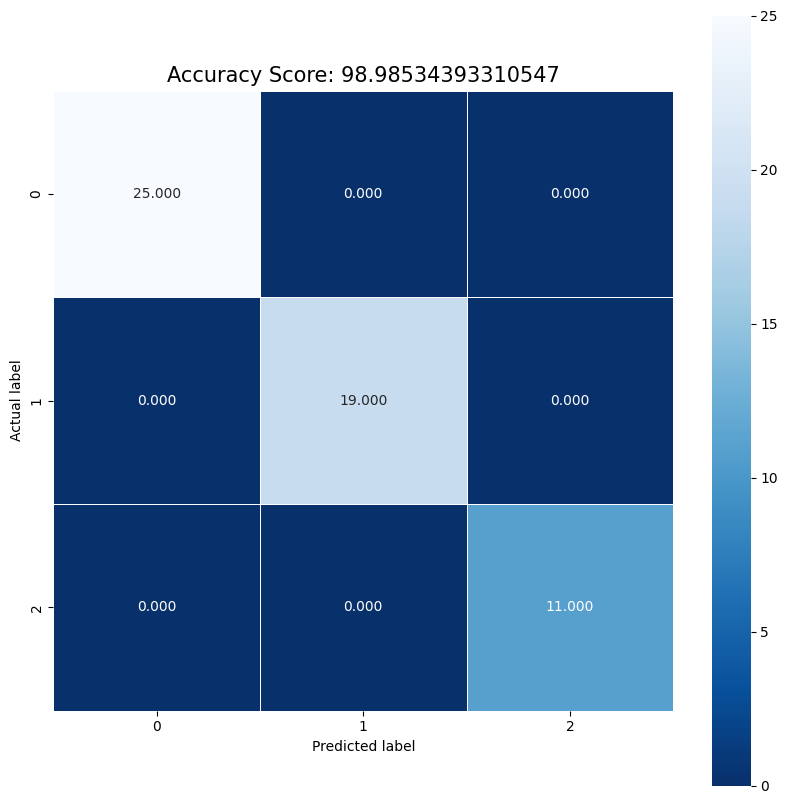

In [44]:
# plot a graphical confusion matrix for the test set using matplotlib
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, predicted)
print(cm)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size=15)
plt.show()

